## 1.Importing the Required Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
import nltk
import re
import string

In [88]:
 nltk.download('punkt')
 nltk.download('wordnet')
 nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
import keras
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import callbacks
from keras.callbacks import EarlyStopping

In [92]:
from bs4 import BeautifulSoup

In [93]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.Loading the Dataset

In [94]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-sentiment-analysis/data.csv


In [95]:
df=pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
df.shape

(5842, 2)

## 3.Checking for Duplicates and Null Values

In [96]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [97]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [98]:
sum(df.duplicated())

6

In [99]:
df=df.drop_duplicates()

In [100]:
df.shape

(5836, 2)

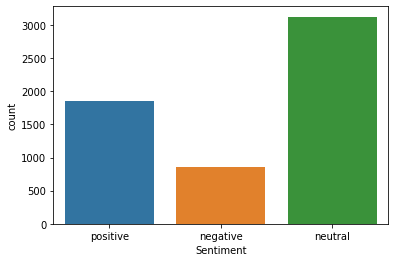

In [101]:
sns.countplot(x='Sentiment',data=df)
plt.show()

Now, let's prepare the data for sentiment analysis

## 4.Text Processing for Sentiment Analysis

In [102]:
#Removal of HTML contents:
def remove_html(text):
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

#Removal of Punctuation Marks:
def remove_punctuations(text):
    return re.sub('\[[^]]*\]','',text)
    
#Removal of special characters:
def remove_characters(text):
    return re.sub('[^a-zA-Z]',' ',text)

#Removal of stopwords:
def remove_stopwords_lemmatization(text):
    final_text=[]
    text=text.lower()
    text=nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma=nltk.WordNetLemmatizer()
            word=lemma.lemmatize(word)
            final_text.append(word)
    return ' '.join(final_text)                  

In [103]:
def cleaning(text):
    text=remove_html(text)
    text=remove_punctuations(text)
    text=remove_characters(text)
    text=remove_stopwords_lemmatization(text)
    return text

#Applying the function
df['Sentence']=df['Sentence'].apply(cleaning)

In [104]:
df.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,positive
1,esi low bk real possibility,negative
2,last quarter componenta net sale doubled eur e...,positive
3,according finnish russian chamber commerce maj...,neutral
4,swedish buyout firm sold remaining percent sta...,neutral


## 5.Splitting into X and y

In [105]:
X=df['Sentence']
y=df['Sentiment']

In [106]:
tokenizer = Tokenizer(num_words=1000, split=' ') 
tokenizer.fit_on_texts(X)
X= tokenizer.texts_to_sequences(X)
X= pad_sequences(X)

In [107]:
X

array([[  0,   0,   0, ...,  21, 459, 265],
       [  0,   0,   0, ...,   0, 251, 137],
       [  0,   0,   0, ..., 197,  27,   1],
       ...,
       [  0,   0,   0, ..., 303,  48, 842],
       [  0,   0,   0, ...,  51,   1,   3],
       [  0,   0,   0, ..., 641, 164, 167]], dtype=int32)

In [108]:
le=LabelEncoder()
y=le.fit_transform(y)

In [109]:
y

array([2, 0, 2, ..., 1, 1, 2])

In [110]:
y=pd.get_dummies(y)

In [111]:
X.shape,X.shape[1]

((5836, 32), 32)

In [112]:
X.shape,y.shape

((5836, 32), (5836, 3))

## 6. Train and Test Split

In [113]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [114]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4960, 32), (876, 32), (4960, 3), (876, 3))

## 7.Model Building and Prediction

In [115]:
from warnings import filterwarnings
filterwarnings('ignore')

In [116]:
model=Sequential()

In [117]:
model.add(Embedding(1000,120,input_length=X.shape[1]))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(64,dropout = 0.1,recurrent_dropout = 0.1))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 32, 120)           120000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32, 128)           127488    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 299,075
Trainable params: 299,075
Non-trainable params: 0
_________________________________________________________________


In [119]:
earlystopping=EarlyStopping(monitor='loss',patience=3)

In [120]:
from warnings import filterwarnings
filterwarnings('ignore')

In [121]:
history=model.fit(X_train,y_train,batch_size=16,validation_data=(X_train,y_train),epochs=100,verbose='auto',callbacks=earlystopping)

Epoch 1/100
310/310 [==============================] - 51s 156ms/step - loss: 0.8846 - accuracy: 0.6089 - val_loss: 0.6874 - val_accuracy: 0.7101
Epoch 2/100
310/310 [==============================] - 48s 156ms/step - loss: 0.6723 - accuracy: 0.7101 - val_loss: 0.5692 - val_accuracy: 0.7694
Epoch 3/100
310/310 [==============================] - 48s 156ms/step - loss: 0.5886 - accuracy: 0.7405 - val_loss: 0.4913 - val_accuracy: 0.7931
Epoch 4/100
310/310 [==============================] - 48s 154ms/step - loss: 0.5166 - accuracy: 0.7631 - val_loss: 0.4552 - val_accuracy: 0.7867
Epoch 5/100
310/310 [==============================] - 48s 155ms/step - loss: 0.4833 - accuracy: 0.7746 - val_loss: 0.4121 - val_accuracy: 0.8062
Epoch 6/100
310/310 [==============================] - 50s 161ms/step - loss: 0.4383 - accuracy: 0.7915 - val_loss: 0.3601 - val_accuracy: 0.8290
Epoch 7/100
310/310 [==============================] - 50s 161ms/step - loss: 0.4108 - accuracy: 0.8079 - val_loss: 0.3307 -

In [122]:
y_pred=model.predict(X_test)

In [123]:
y_pred=np.round(y_pred)

## 8.Model Evaluation

In [124]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.19      0.24       124
           1       0.71      0.78      0.75       485
           2       0.67      0.63      0.65       267

   micro avg       0.66      0.65      0.66       876
   macro avg       0.57      0.54      0.54       876
weighted avg       0.64      0.65      0.64       876
 samples avg       0.65      0.65      0.65       876



We can see that the model is 66% accurate in predicting the sentiments.
